In [241]:
#importing packages
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import scipy.optimize as spop
import matplotlib.pyplot as plt
#https://www.youtube.com/watch?v=jvZ0vuC9oJk&list=PLE4a3phdCOauXaK3f1QMI_fEIqEYTsH9I&index=3
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 20)

In [242]:
#specifying parameters
#stocks = ['JPM','C']
#stocks = ['KO','PEP']
stocks = ['JPM','UBS']
stocks = ['MSFT','GOOGL']
start = '2018-12-31'
end = '2021-03-08'
fee = 0.001
window = 252 # this is the rolling window
t_threshold = -1.5 # from dickey and fuller unit root test, more negative is better
#retrieving data
df = pd.DataFrame()
returns = pd.DataFrame()
for stock in stocks:
    prices = yf.download(stock, start, end)
    df[stock+'_price'] = prices['Adj Close']
    df[stock+'_return'] = prices['Adj Close'].pct_change().shift(-1)
    # important! need to match today's price (or signal) with tomorrow's return in the same df row for backtesting
    
df = df[:-1]
df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,MSFT_price,MSFT_return,GOOGL_price,GOOGL_return
Date,,,,
2018-12-31,98.813278,-0.004431,1044.959961,0.009302
2019-01-02,98.375481,-0.036788,1054.680054,-0.027696
2019-01-03,94.756454,0.046509,1025.469971,0.051294
2019-01-04,99.163513,0.001275,1078.069946,-0.001994
2019-01-07,99.289970,0.007251,1075.920044,0.008783
2019-01-08,100.009888,0.014300,1085.369995,-0.003427
2019-01-09,101.439995,-0.006425,1081.650024,-0.002607
2019-01-10,100.788193,-0.007722,1078.829956,-0.013311
2019-01-11,100.009888,-0.007296,1064.469971,-0.012175


## Unit root

Assume $X_t=\alpha+\rho*X_{t-1}+\epsilon_t$  
$X_t-X_{t-1}=\alpha+(\rho-1)*X_{t-1+\epsilon_t}$

**Dickey Fuller test**

$H_0:\rho=1$  
$H_1:\rho=0$  

So more significant the t statistic is, the more we can reject Ho (no unit root), the better we can say series is not non-stationary

In [243]:
%%time

#initialising arrays
stock1 = stocks[0]
stock2 = stocks[1]
df['t_optimal'] = 0.0 # make it carry float
df['net_return'] = 0.0 # make it carry float
df['long stock 1'] = 0
df['long stock 2'] = 0
# moving through the sample
for t in range(window, len(df)):
    
    # defining the unit root function: stock2 = a + b*stock1
    def unit_root(b):
        a = np.average(df[stock2+'_price'][t-window:t] - b*df[stock1+'_price'][t-window:t]) # make avg residual the intercept
        # https://statisticsbyjim.com/regression/interpret-constant-y-intercept-regression/
        fair_value = a + b*df[stock1+'_price'][t-window:t]
        diff = np.array(fair_value - df[stock2+'_price'][t-window:t])
        diff_diff = diff[1:] - diff[:-1]
        reg = sm.OLS(diff_diff, diff[:-1])
        res = reg.fit()
        return res.params[0]/res.bse[0] # calculating t stat by doing (coefficient/standard error)
    
    # optimising the cointegration equation parameters
    res1 = spop.minimize(unit_root, df[stock2+'_price'][t]/df[stock1+'_price'][t], method='Nelder-Mead')
    t_opt = res1.fun
    b_opt = float(res1.x)
    a_opt = np.average(df[stock2+'_price'][t-window:t] - b_opt*df[stock1+'_price'][t-window:t])

    # core trading strategy
    fair_value = a_opt + b_opt*df[stock1+'_price'][t]
    if t == window: # starting point
        old_signal = 0
    if t_opt > t_threshold: # nothing happens
        signal = 0
        gross_return = 0
        df['t_optimal'].iloc[t,:] = float(t_opt)
        df['net_return'].iloc[t,:] = gross_return
    elif t_opt < t_threshold: # trigger trading signal when more negative
        signal = np.sign(fair_value - df[stock2+'_price'][t]) # if + then long stock2 short stock1
        df['long stock 1'].iloc[t,:] = -signal
        df['long stock 2'].iloc[t,:] = signal
        gross_return = signal*df[stock2+'_return'][t] + (-signal*df[stock1+'_return'][t])
        fees = fee*abs(signal - old_signal)
        net_return = gross_return - fees
        df['t_optimal'].iloc[t,:] = float(t_opt)
        df['net_return'].iloc[t,:] = net_return
    
    old_signal = signal

df['open long stock 1'] = df['long stock 1'].diff()
df['open long stock 2'] = df['long stock 2'].diff()

C:\Users\xcy99\Desktop\pycharm\scientificProject\env\lib\site-packages\pandas\core\indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Wall time: 22.8 s


In [244]:
#pd.set_option('display.max_rows', 100)
#pd.set_option('display.expand_frame_repr', True)
df[window-1:]

,MSFT_price,MSFT_return,GOOGL_price,GOOGL_return,t_optimal,net_return,long stock 1,long stock 2,open long stock 1,open long stock 2
Date,,,,,,,,,,
2019-12-30,155.579727,0.000698,1339.709961,-0.000239,0.000000,0.000000,0,0,0.0,0.0
2019-12-31,155.688324,0.018516,1339.390015,0.021868,-2.100169,-0.004352,1,-1,1.0,-1.0
2020-01-02,158.571075,-0.012452,1368.680054,-0.005231,-2.065062,-0.007220,1,-1,0.0,0.0
2020-01-03,156.596588,0.002585,1361.520020,0.026654,-2.030965,-0.024069,1,-1,0.0,0.0
2020-01-06,157.001373,-0.009118,1397.810059,-0.001932,-1.941363,-0.007186,1,-1,0.0,0.0
2020-01-07,155.569855,0.015928,1395.109985,0.007118,-1.814693,0.008811,1,-1,0.0,0.0
2020-01-08,158.047836,0.012493,1405.040039,0.010498,-1.809642,0.001995,1,-1,0.0,0.0
2020-01-09,160.022308,-0.004627,1419.790039,0.006459,-1.787270,-0.011086,1,-1,0.0,0.0
2020-01-10,159.281876,0.012024,1428.959961,0.007747,-1.770480,0.004277,1,-1,0.0,0.0


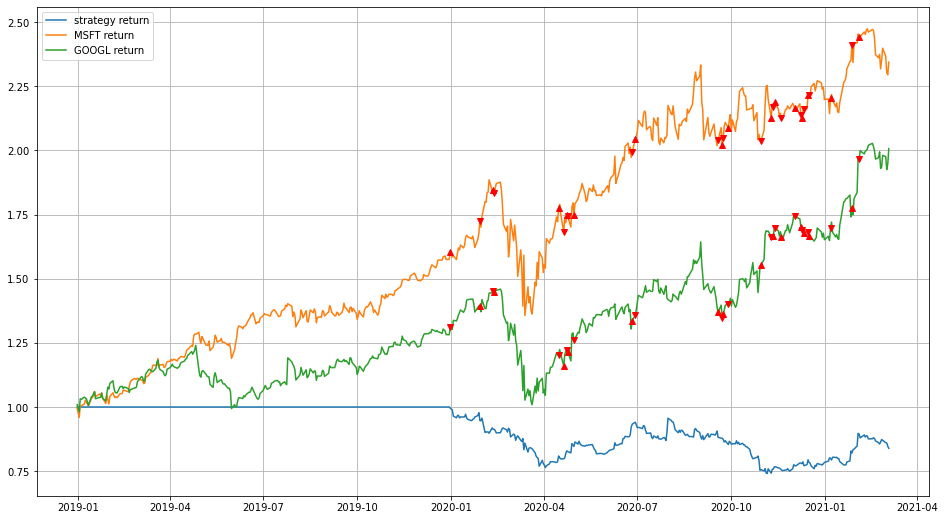

In [245]:
plt.figure(figsize=(16,9))
# since not using log return initially, so have to use (1+r1)*(1+r2)
plt.plot((df['net_return']+1).cumprod())
plt.plot((df[stock1+'_return']+1).cumprod())
plt.plot((df[stock2+'_return']+1).cumprod())
plt.legend(['strategy return',stock1+' return',stock2+' return'])
plt.grid()
for i in range(0,len(df)):
    if df['open long stock 1'][i] > 0:
        plt.plot(df.index[i],(df[stock1+'_return']+1).cumprod()[i],'r^')
    if df['open long stock 1'][i] < 0:
        plt.plot(df.index[i],(df[stock1+'_return']+1).cumprod()[i],'rv')
    if df['open long stock 2'][i] > 0:
        plt.plot(df.index[i],(df[stock2+'_return']+1).cumprod()[i],'r^')
    if df['open long stock 2'][i] < 0:
        plt.plot(df.index[i],(df[stock2+'_return']+1).cumprod()[i],'rv')